In [5]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import pandas as pd
import numpy as np
from pacmagic_deeplearning.modeling.classifiers.bayesian.train_utils import make_performance_uncertainty_plot, cross_entropy

from utils import get_weight_tensor_from_class_weights, train, plot_calibration_curve, make_precision_accuracy_plot
from utils import NN

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
X_train = pd.read_csv('../../data/MIMIC/X_train_processed.csv')
y_train = pd.read_csv('../../data/MIMIC/y_train.csv')

X_test = pd.read_csv('../../data/MIMIC/X_test_processed.csv')
y_test = pd.read_csv('../../data/MIMIC/y_test.csv')

In [7]:
data = torch.from_numpy(X_train.values).float()
target = torch.from_numpy(y_train.values).float()

data_val = torch.from_numpy(X_test.values).float()
target_val = torch.from_numpy(y_test.values).float()

In [8]:
quantiles = np.linspace(0, 1, 11)
quantiles = [0.4, 0.5, 0.6]
quantiles

[0.4, 0.5, 0.6]

In [9]:
canonical = NN(quantiles=[0.5])
optimizer = torch.optim.Adam(canonical.parameters(), lr=1e-2)
canonical = train(canonical, data, target, data_val,
                 target_val, optimizer, [0.5])

Validation loss: 0.32, Train loss: 0.34
Validation loss: 0.18, Train loss: 0.20
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08


In [10]:
model = NN(quantiles=quantiles)

model.z = canonical.z
model.z.weight.requires_grad = False
model.z.bias.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

model = train(model, data, target, 
             data_val, target_val, optimizer, quantiles)

Validation loss: 1.01, Train loss: 1.08
Validation loss: 0.36, Train loss: 0.37
Validation loss: 0.28, Train loss: 0.28
Validation loss: 0.27, Train loss: 0.26
Validation loss: 0.26, Train loss: 0.25
Validation loss: 0.26, Train loss: 0.25
Validation loss: 0.26, Train loss: 0.25
Validation loss: 0.26, Train loss: 0.25
Validation loss: 0.25, Train loss: 0.25
Validation loss: 0.25, Train loss: 0.25
Validation loss: 0.25, Train loss: 0.25
Validation loss: 0.25, Train loss: 0.25
Validation loss: 0.25, Train loss: 0.25
Validation loss: 0.25, Train loss: 0.25
Validation loss: 0.25, Train loss: 0.25
Validation loss: 0.25, Train loss: 0.25
Validation loss: 0.25, Train loss: 0.25
Validation loss: 0.25, Train loss: 0.25
Validation loss: 0.25, Train loss: 0.25
Validation loss: 0.25, Train loss: 0.25
Validation loss: 0.25, Train loss: 0.25
Validation loss: 0.25, Train loss: 0.25
Validation loss: 0.25, Train loss: 0.25
Validation loss: 0.25, Train loss: 0.25
Validation loss: 0.25, Train loss: 0.25


In [11]:
outputs_val = model(data_val)

In [12]:
outputs = [torch.sigmoid(output) for output in outputs_val]

In [13]:
plots = []

for output in outputs:
    plots.append(plot_calibration_curve(y_test, output.detach().numpy()))

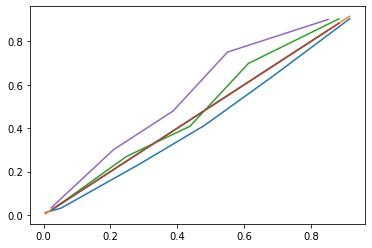

In [14]:
for plot in plots:
    plt.plot(plot[0], plot[1])
    plt.plot(plot[0], plot[0])
    
plt.show()

In [15]:
outputs_val = torch.stack([torch.sigmoid(output_val.squeeze()) for output_val in outputs_val], dim=1).detach().numpy().round(3)

In [16]:
# optimal cutoff point
cutoff = np.percentile(outputs_val[:, 1], 100 * (1-y_train.values.mean()))
cutoff

0.2805190057281374

In [17]:
preds = (outputs_val > cutoff)

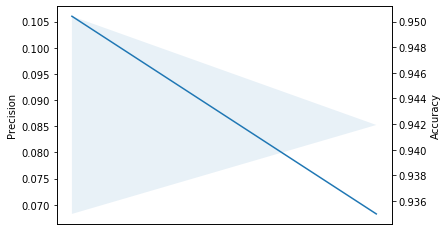

In [18]:
make_precision_accuracy_plot(outputs_val, preds, y_test)

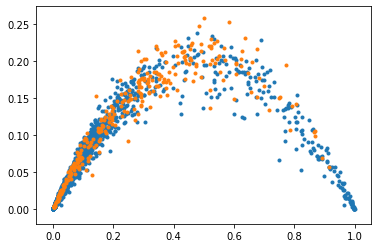

In [19]:
# uncertainties = np.var(outputs_val, axis=-1)
# uncertainties = outputs_val[:, 1] - outptus_val[:, 9]
# uncertainties = outputs_val[:, 2] - outputs_val[:, 8]
# uncertainties = outputs_val[:, 3] - outputs_val[:, 7]
uncertainties = outputs_val[:, 0] - outputs_val[:, 2]

preds_50 = preds[:, 1]
plt.scatter(outputs_val[:, 1][preds_50 == y_test.squeeze().values], uncertainties[preds_50 == y_test.squeeze().values], marker='.')
plt.scatter(outputs_val[:, 1][preds_50 != y_test.squeeze().values], uncertainties[preds_50 != y_test.squeeze().values], marker='.')


In [20]:
y_true = y_test.values.squeeze(-1)
y_prob = outputs_val[:, 1]
y_unc = uncertainties

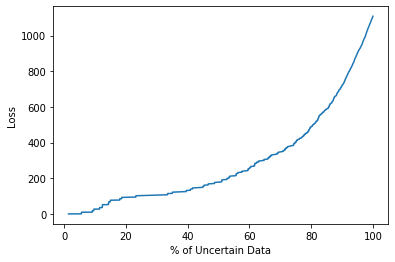

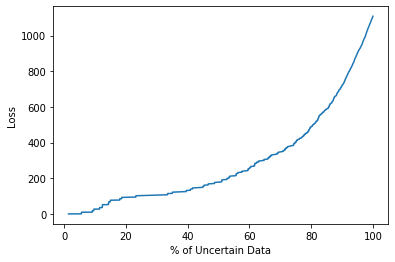

In [21]:
make_performance_uncertainty_plot(y_true, y_prob, y_unc, 'Loss', performance_fn_args={'reduction': 'sum'})

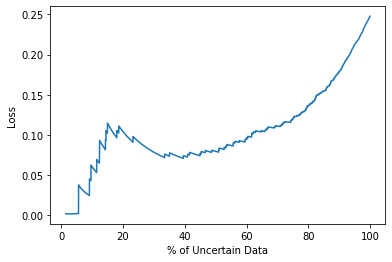

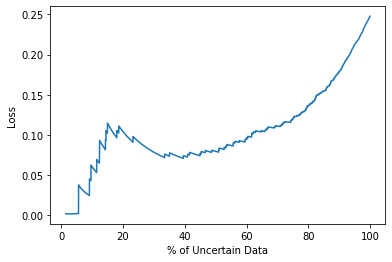

In [22]:
make_performance_uncertainty_plot(y_true, y_prob, y_unc, 'Loss', performance_fn_args={'reduction': 'mean'})

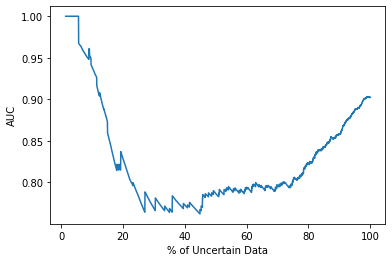

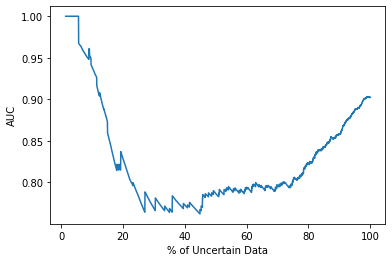

In [23]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'AUC', performance_fn=roc_auc_score)

In [24]:
from utils import loss_at_50

In [25]:
loss_at_50(y_true, y_prob, uncertainties)

178.17967840877827

## Asymmetric entropy baseline

In [26]:
def asymmetric_entropy(p, w):
    return (p * (1 - p)) / ((-2 * w + 1) * p + w ** 2)


In [30]:
uncertainties = asymmetric_entropy(outputs_val[:, 1], y_train.values.mean())

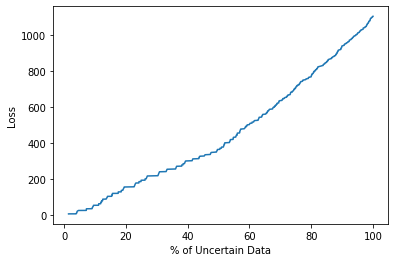

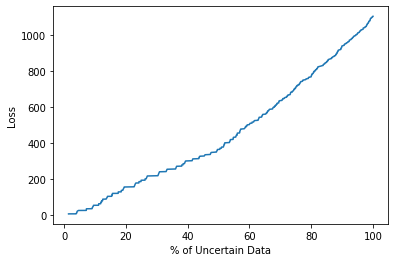

In [31]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'Loss', performance_fn_args={'reduction': 'sum'})

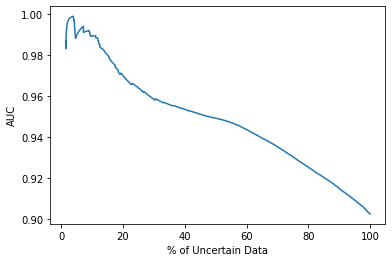

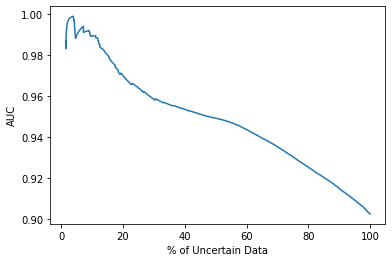

In [32]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'AUC', performance_fn=roc_auc_score)

In [33]:
loss_at_50(y_true, y_prob, uncertainties)

365.1578038040316